In [1]:
# Uncomment line below to install exlib
# !pip install exlib
# !pip install diskcache
import sys; sys.path.insert(0, "../../exlib/src")
import exlib

ROOT_DIR = '..'

In [2]:
import torch
from datasets import load_dataset
from exlib.datasets.mass_maps import MassMapsDataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Load data
train_dataset = MassMapsDataset(split="train")
val_dataset = MassMapsDataset(split="validation")

In [4]:
import openai
from getpass import getpass
import os

with open(f"{ROOT_DIR}/API_KEY.txt", "r") as file:
    api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
os.environ['CACHE_DIR'] = os.path.join(ROOT_DIR, 'cache_dir')

# openai.api_key = getpass('Enter your OpenAI API key: ')
# os.environ['OPENAI_API_KEY'] = openai.api_key

In [5]:
from massmaps import MassMapsExample
from massmaps import massmap_to_pil_norm, get_llm_generated_answer
from massmaps import isolate_individual_features, distill_relevant_features, calculate_expert_alignment_score

# Get Few-shot Examples

In [ ]:
train_dataset['label'].min(dim=0), train_dataset['label'].max(dim=0)

In [ ]:
few_shot_numbers = [0, 1, 14, 19]

In [ ]:
for i in range(20):
    print(i, train_dataset['label'][i])

In [ ]:
from massmaps import massmap_to_pil_norm
import matplotlib.pyplot as plt

relevance_few_shot_examples = []
for i, idx in enumerate(few_shot_numbers):
    X, y = train_dataset[idx:idx+1]['input'], train_dataset[idx:idx+1]['label']
    relevance_few_shot_examples.append({'idx': idx, 'X': X, 'y': y})
    plt.figure()
    plt.imshow(massmap_to_pil_norm(X[0]))
    plt.axis('off')
    # plt.title(f'$\Omega_m$ {round(y[0][0].item(), 4)},   $\sigma_8$ {round(y[0][1].item(), 4)}')
    plt.savefig(os.path.join(ROOT_DIR, f'src/prompts/massmaps_relevance_few_shot_examples.{i}.Omega{round(y[0][0].item(), 4)}.sigma{round(y[0][1].item(), 4)}.png'), 
                dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
relevance_few_shot_examples[0].update({
    'claim': 'The dataset represents the spatial distribution of matter density in the universe.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'This is a general statement and does not justify any specific prediction.'
})
relevance_few_shot_examples[1].update({
    'claim': 'The weak lensing map shows several yellow pixels close to each other on the left side, suggesting the existence of high-density regions or clusters.',
    'relevance_answer': 'YES',
    'relevance_explanation': 'This is a specific cosmological structure observable in the data and indicative of cosmological parameters such as sigma_8.'
})
relevance_few_shot_examples[2].update({
    'claim': 'Voids are large low density regions in space.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'This is background knowledge, not derived from the data.'
})
relevance_few_shot_examples[3].update({
    'claim': 'There is a gray pixel in the upper left corner with value 6.2992e-04 in the data.',
    'relevance_answer': 'NO',
    'relevance_explanation': 'Simply listing pixel values does not explain a prediction.'
})

In [ ]:
import torch

torch.save({
    'split': 'train',
    'examples': relevance_few_shot_examples
}, 'few_shot_examples/massmaps/relevance_examples.pt')


# Experiments

In [ ]:
# import torch

# relevance_few_shot_examples_path = 'few_shot_examples/massmaps/relevance_examples.pt'
# relevance_few_shot_examples = torch.load(relevance_few_shot_examples_path)['examples']

In [ ]:
# len(relevance_few_shot_examples), relevance_few_shot_examples[0]

In [6]:
from tqdm.auto import tqdm

massmaps_examples = []
for idx in tqdm(range(2)):
    X, y = val_dataset[idx:idx+1]['input'], val_dataset[idx:idx+1]['label']
    image = X[0]
    label = y[0]
    llm_answer, llm_explanation = get_llm_generated_answer(image)
    # rating, explanation = get_llm_generated_answer(row['Utterance'])
    if llm_answer is None:
        continue
    massmaps_examples.append(MassMapsExample(
        input=image,
        answer={"Omega_m": label[0].item(), "sigma_8": label[1].item()},
        llm_answer=llm_answer,
        llm_explanation=llm_explanation
    ))

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
for example in massmaps_examples:
    claims = isolate_individual_features(example.llm_explanation)
    if claims is None:
        continue
    example.claims = [claim.strip() for claim in claims]

In [8]:
massmaps_examples[0].claims

['The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean.',
 'The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters.',
 'The yellow regions, in particular, represent areas above 3 standard deviations, confirming the presence of clusters.',
 'The blue areas indicate voids, where the matter density is significantly lower.',
 'The balance between these voids and clusters can provide insights into the cosmological parameters Omega_m and sigma_8.',
 'A higher density of clusters (yellow and red regions) suggests a higher value of sigma_8, which measures the amplitude of matter fluctuations.',
 'The distribution and size of voids and clusters also inform Omega_m, the matter density parameter.',
 'Given the substantial presence of clusters and moderate voids, this map suggests a relatively high Omega_m and sigma_8.',
 'A relatively high Omeg

In [9]:
for example in massmaps_examples:
    relevant_claims = distill_relevant_features(
        example.input, 
        example.llm_answer,
        example.claims
    )
    example.relevant_claims = relevant_claims

Found 4 few_shot_images:
  • massmaps_relevance_few_shot_examples.0.Omega0.1041.sigma0.9396.png
  • massmaps_relevance_few_shot_examples.1.Omega0.3934.sigma0.7018.png
  • massmaps_relevance_few_shot_examples.2.Omega0.3586.sigma0.9762.png
  • massmaps_relevance_few_shot_examples.3.Omega0.4612.sigma0.5614.png
Found 4 few_shot_images:
  • massmaps_relevance_few_shot_examples.0.Omega0.1041.sigma0.9396.png
  • massmaps_relevance_few_shot_examples.1.Omega0.3934.sigma0.7018.png
  • massmaps_relevance_few_shot_examples.2.Omega0.3586.sigma0.9762.png
  • massmaps_relevance_few_shot_examples.3.Omega0.4612.sigma0.5614.png
Found 4 few_shot_images:
  • massmaps_relevance_few_shot_examples.0.Omega0.1041.sigma0.9396.png
  • massmaps_relevance_few_shot_examples.1.Omega0.3934.sigma0.7018.png
  • massmaps_relevance_few_shot_examples.2.Omega0.3586.sigma0.9762.png
  • massmaps_relevance_few_shot_examples.3.Omega0.4612.sigma0.5614.png
Found 4 few_shot_images:
  • massmaps_relevance_few_shot_examples.0.Omega

In [10]:
massmaps_examples[0].relevant_claims

['The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean.',
 'The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters.',
 'The yellow regions, in particular, represent areas above 3 standard deviations, confirming the presence of clusters.',
 'The blue areas indicate voids, where the matter density is significantly lower.',
 'The balance between these voids and clusters can provide insights into the cosmological parameters Omega_m and sigma_8.',
 'A higher density of clusters (yellow and red regions) suggests a higher value of sigma_8, which measures the amplitude of matter fluctuations.',
 'The distribution and size of voids and clusters also inform Omega_m, the matter density parameter.',
 'Given the substantial presence of clusters and moderate voids, this map suggests a relatively high Omega_m and sigma_8.',
 'A relatively high Omeg

In [11]:
import copy

massmaps_examples_deepresearch = copy.deepcopy(massmaps_examples)

In [14]:
for example in massmaps_examples:
    alignment_scores = []
    alignment_categories = []
    for claim in tqdm(example.relevant_claims):
        category, alignment_score, reasoning = calculate_expert_alignment_score(example.input, example.llm_prediction, claim)
        if category is None:
            continue
        alignment_scores.append(alignment_score)
        alignment_categories.append(category)
    example.alignment_scores = alignment_scores
    example.alignment_categories = alignment_categories

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
massmaps_examples[0].alignment_categories

['Clusters', 'Clusters', 'Voids/Clusters', 'Clusters', 'Clusters']

In [17]:
for i in range(len(massmaps_examples)):
    print(i, massmaps_examples[i].alignment_scores)

0 [4, 5, 5, 5, 5]
1 [4, 5, 5, 5, 5]
2 [4, 4, 5]
3 [4, 4, 5, 5, 5, 4]
4 [4, 5, 5, 5, 5]
5 [4, 5, 5, 5, 5, 4]
6 [5, 5, 5, 5, 5, 4]
7 [5, 5, 5, 4, 4]
8 [4, 5, 4, 5, 5, 4]
9 [5, 5, 5]
10 [5, 5, 5, 4]
11 [4, 3, 5, 5]
12 [4, 5, 5, 5, 4]
13 [4, 4, 5, 5]
14 [4, 5, 4, 5, 5, 5]
15 [4, 5, 3, 5, 5]
16 [4, 5, 5, 5, 5, 4]
17 [4, 4, 5, 5, 5, 4]
18 [4, 4, 5, 4]
19 [4, 5, 3, 4, 5, 5]


In [25]:
deepresearch_prompt = """Single-Claim Expert Alignment Evaluation

You are a cosmologist. You will judge one explanatory claim about how a weak-lensing map informs $\Omega_m$ and $\sigma_8$.

**Step 1. For each Point below, choose exactly one label:**
- Aligned (the claim invokes this feature in a physically correct way)
- Neutral (the claim neither helps nor harms; the feature is not relevant)
- Misaligned (the claim invokes this feature in a way that contradicts expert knowledge)

**Points & Criteria**
1. **Peaks**
   - Aligned: mentions abundance or height of high-convergence (cluster) peaks and correctly ties higher peak counts/heights to higher $\sigma_8$/$\Omega_m$.
   - Neutral: says nothing about peaks.
   - Misaligned: refers to "peaks" but gets their cosmological dependence backward (e.g. "fewer peaks -> higher $\sigma_8$").

2. **Voids**
   - Aligned: references low-$\kappa$ regions (voids/minima) and correctly states that deeper/more voids indicate higher $\sigma_8$ (in noiseless maps) or explains noise limitations.
   - Neutral: no mention of voids.
   - Misaligned: claims voids deepen with lower $\sigma_8$ or ignores that noise washes out void signals in real maps.

3. **Statistics**
   - Aligned: appeals to ensemble measures (e.g. counts histogram, PDF moments, Minkowski functionals) rather than a single pixel.
   - Neutral: does not invoke any summary statistic.
   - Misaligned: treats a single pixel or arbitrary detail as if it alone constrains cosmology.

4. **Scale & Noise**
   - Aligned: specifies a sensible angular scale or S/N threshold (e.g. peaks with S/N ≥ 2–3, multi-arcmin smoothing) where the feature is reliable.
   - Neutral: no reference to scale or noise constraints.
   - Misaligned: cites very small-scale features (<1′) or ignores that shape noise dominates low S/N peaks.

5. **Degeneracy & Combo**
   - Aligned: acknowledges that $\Omega_m$ and $\sigma_8$ are partially degenerate and mentions combining ≥2 features (e.g. peaks+voids).
   - Neutral: does not address parameter degeneracy at all.
   - Misaligned: claims a single feature uniquely fixes both $\Omega_m$ and $\sigma_8$.

6. **Systematics**
   - Aligned: avoids over-claiming based on features strongly affected by baryons or survey biases (e.g. very small-scale peaks).
   - Neutral: no mention of systematics or modeling uncertainty.
   - Misaligned: uses features known to be unreliable (e.g. pixel-level fluctuations, unmodeled baryonic effects) as decisive evidence.

**Step 2. Compute the numeric Score:**
- Assign +1 to each Aligned, 0 to Neutral, –1 to Misaligned.
- Sum these values, then clamp to the nearest integer within [-2, 2].

**Step 3. Output (exactly):**
```json
{
    "evaluations": {
        "peaks":           "<Aligned|Neutral|Misaligned>",
        "voids":           "<Aligned|Neutral|Misaligned>",
        "statistics":      "<Aligned|Neutral|Misaligned>",
        "scale & noise":   "<Aligned|Neutral|Misaligned>",
        "degeneracy & combo": "<Aligned|Neutral|Misaligned>",
        "systematics":     "<Aligned|Neutral|Misaligned>"
    },
    "category": "<peaks|voids|statistics|scale & noise|degeneracy & combo|systematics>",
    "explanation": "<explanation for scoring decision process>", # you can include the process of getting the score here.
    "raw_score": <-2 | -1 | 0 | 1 | 2> # only out a single number as an int and do not include the process of getting the score. If the number is above 2 or below -2, please make sure to clamp it.
    "score": <1 | 2 | 3 | 4 | 5> # rescale the raw score by adding 3 to it so that the range is between 1 and 5.
}
```

*Examples of correct vs. incorrect answers:*
- If the claim is "Many high-S/N peaks suggest high $\sigma_8$", then  
  ```  
  Peaks: Aligned  
  // all others: Neutral  
  Score = +1 -> 1  
  ```
- If the claim is "This single tiny bump means $\Omega_m$ is low", then  
  ```  
  Peaks: Misaligned  
  Statistics: Misaligned  
  // others: Neutral  
  Score = (-1)+(-1) = -2 -> -2  
  ```
- If the claim is "A few deep voids hint at high $S_8$, but it could be noise", then  
  ```  
  Voids: Aligned  
  Scale & Noise: Aligned  
  // others: Neutral  
  Score = +1+1 = 2 -> 2  
  ```  
Use this rubric to assign both a clear numeric score and a point-by-point judgment for any single claim.
"""

In [26]:
for example in massmaps_examples_deepresearch:
    alignment_scores = []
    alignment_categories = []
    for claim in tqdm(example.relevant_claims):
        category, alignment_score, reasoning = calculate_expert_alignment_score(example.input, example.llm_prediction, claim, system_prompt=deepresearch_prompt)
        if category is None:
            continue
        alignment_scores.append(alignment_score)
        alignment_categories.append(category)
    example.alignment_scores = alignment_scores
    example.alignment_categories = alignment_categories

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
for i in range(len(massmaps_examples_deepresearch)):
    print(i, massmaps_examples_deepresearch[i].alignment_scores)

0 [4, 5, 5, 4, 3]
1 [4, 4, 5, 4, 5]
2 [3, 4, 5]
3 [3, 4, 5, 4, 5, 5]
4 [4, 5, 5, 5, 5]
5 [4, 5, 5, 5, 5, 4]
6 [4, 5, 5, 4, 5, 5]
7 [5, 4, 5, 4, 4]
8 [4, 4, 3, 5, 5, 4]
9 [5, 4, 5]
10 [5, 4, 5, 5]
11 [4, 2, 5, 5]
12 [4, 5, 5, 3, 2]
13 [4, 4, 5, 5]
14 [4, 5, 2, 4, 5, 3]
15 [4, 5, 3, 3, 5]
16 [3, 5, 5, 3, 1, 1]
17 [4, 4, 5, 4, 5, 4]
18 [3, 4, 5, 4]
19 [4, 5, 3, 3, 5, 3]


In [28]:
os.makedirs('_dump', exist_ok=True)

torch.save({
    'massmaps_examples': massmaps_examples,
    'massmaps_examples_deepresearch': massmaps_examples_deepresearch
}, '_dump/massmaps_examples_prototype.pt')

In [29]:
same = 0
old_high = 0
new_high = 0
for i in range(len(massmaps_examples)):
    if massmaps_examples[i].alignment_scores == massmaps_examples_deepresearch[i].alignment_scores:
        same += 1
    elif massmaps_examples[i].alignment_scores > massmaps_examples_deepresearch[i].alignment_scores:
        old_high += 1
    else:
        new_high += 1
print(same, old_high, new_high)

3 17 0


In [30]:
reasoning

'The claim correctly associates many clusters (peaks) with higher sigma_8, which is aligned. However, it incorrectly states that fewer voids suggest higher sigma_8, which is misaligned as deeper/more voids are expected with higher sigma_8 in noiseless maps.'

In [31]:
claim

'The presence of many clusters and fewer voids suggests a higher sigma_8, indicating stronger fluctuations in the matter distribution.'

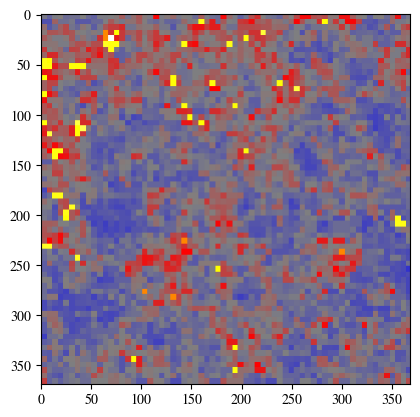

--- Answer ---
{'Omega_m': 0.1845703125, 'sigma_8': 0.9883788824081421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters. The yellow regions, in particular, represent areas above 3 standard deviations, confirming the presence of clusters. The blue areas indicate voids, where the matter density is significantly lower. The balance between these voids and clusters can provide insights into the cosmological parameters Omega_m and sigma_8. A higher density of clusters (yellow and red regions) suggests a higher value of sigma_8, which measures the amplitude of matter fluctuations. The distribution and size of voids and clusters also inform Omega_m, the matter density parameter. Given the substant

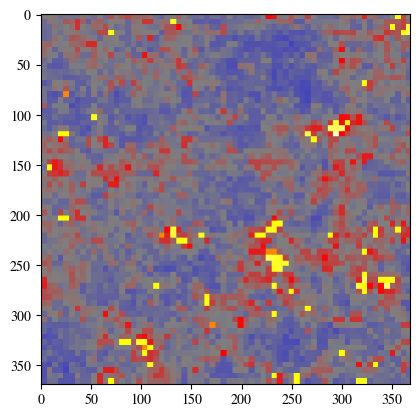

--- Answer ---
{'Omega_m': 0.10371093451976776, 'sigma_8': 1.190527319908142}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of yellow and white regions suggests significant matter overdensities, indicating galaxy clusters. These clusters are more frequent and prominent, suggesting a higher matter density in the universe. The red regions, which are less dense than the yellow and white but still above average, indicate areas of moderate overdensity. The blue regions represent voids, areas with lower matter density. The balance between these voids and clusters can help infer cosmological parameters. A higher frequency of clusters compared to voids suggests a higher Omega_m, indicating a universe with more matter. The presence of significant structures also suggests a higher sigma_8, indicating more pron

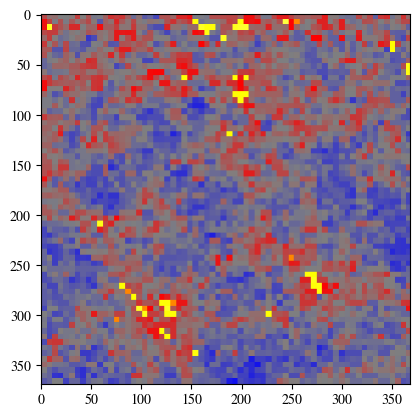

--- Answer ---
{'Omega_m': 0.29082030057907104, 'sigma_8': 0.4727539122104645}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of blue areas indicates voids, where the matter density is significantly lower than average. These voids are crucial for understanding the large-scale structure of the universe. The red areas, which are more prevalent, suggest regions of higher matter density but not quite dense enough to be considered clusters. The yellow areas, although less frequent, indicate clusters where the matter density is significantly higher. The balance between these voids and clusters can inform us about the cosmological parameters Omega_m and sigma_8. A higher frequency of clusters (yellow) suggests a higher value of sigma_8, indicating more pronounced matter fluctuations. The presence of both voi

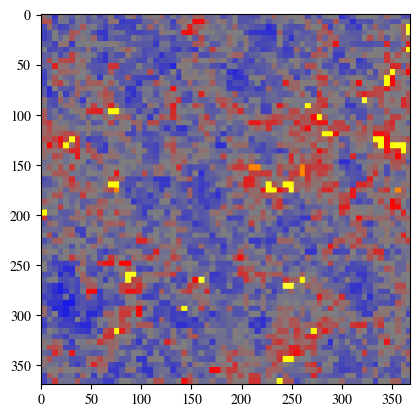

--- Answer ---
{'Omega_m': 0.2787109315395355, 'sigma_8': 0.7530273199081421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of blue areas indicates voids, where the matter density is significantly lower than average. These voids are essential for understanding the large-scale structure of the universe. The gray areas represent regions with average matter density. Red areas, which are more prevalent, indicate regions with higher matter density but not high enough to be considered clusters. The yellow areas, although less frequent, represent clusters where the matter density is significantly higher. The distribution and frequency of these clusters and voids provide insights into the cosmological parameters. A higher frequency of clusters suggests a higher value of sigma_8, which measures the amplitude 

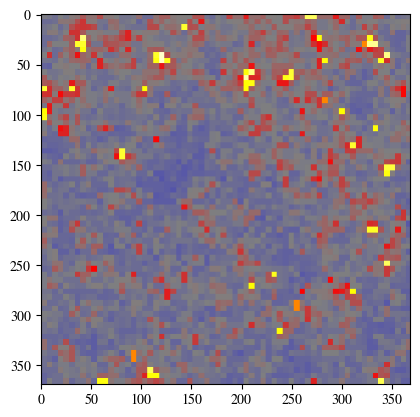

--- Answer ---
{'Omega_m': 0.12451171875, 'sigma_8': 1.157080054283142}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters. These clusters are represented by values above 3 standard deviations, with yellow indicating the highest density. The blue areas represent voids, where the matter density is significantly lower, below -3 standard deviations. The balance between these voids and clusters provides insights into the cosmological parameters. A higher density of clusters compared to voids suggests a higher matter density parameter, Omega_m, as it indicates more matter in the universe. The presence of both significant voids and clusters suggests a moderate level of matter clumping, which is rel

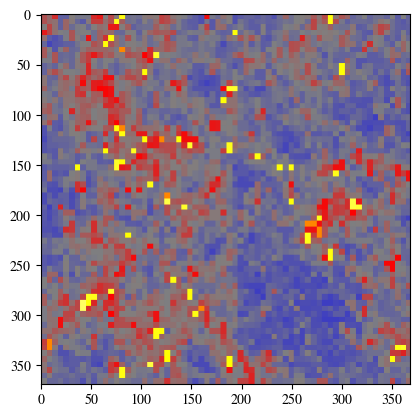

--- Answer ---
{'Omega_m': 0.17539063096046448, 'sigma_8': 0.9654296636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous red and yellow regions suggests a significant number of high-density areas, indicating galaxy clusters. These clusters are represented by values above 3 standard deviations, with yellow indicating the highest density regions. The blue areas represent voids, where the matter density is significantly lower, below -3 standard deviations. The balance between these voids and clusters provides insights into the cosmological parameters. A higher density of clusters compared to voids suggests a higher matter density parameter, Omega_m, as more matter is clumped together. The presence of distinct clusters and voids also indicates a higher value of sigma_8, which measures the

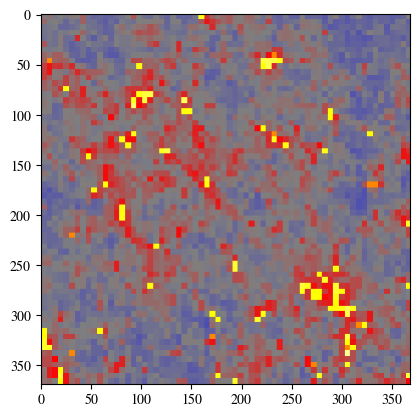

--- Answer ---
{'Omega_m': 0.13437500596046448, 'sigma_8': 0.9859374761581421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of red and yellow regions suggests areas of higher matter density, indicating potential galaxy clusters. The yellow areas, in particular, represent regions above 3 standard deviations, confirming the presence of clusters. The blue areas indicate voids, where the matter density is significantly lower. The balance between these voids and clusters can provide insights into the cosmological parameters Omega_m and sigma_8. A higher density of clusters (yellow regions) suggests a higher value of Omega_m, indicating more matter in the universe. Similarly, the presence of significant clustering can imply a higher sigma_8, reflecting greater matter density fluctuations. The map shows a 

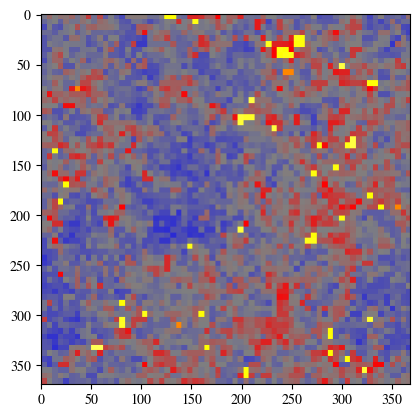

--- Answer ---
{'Omega_m': 0.1748046875, 'sigma_8': 0.7198241949081421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of blue areas indicates voids, where the matter density is significantly below average. These voids suggest a lower Omega_m, as they represent underdense regions. The red and yellow areas indicate higher matter density, with yellow representing clusters where the density exceeds 3 standard deviations. The presence of numerous clusters suggests a higher sigma_8, indicating significant matter clustering. The balance between voids and clusters in this map suggests a moderate Omega_m, as there are both underdense and overdense regions. The presence of several yellow clusters, but not overwhelmingly so, points to a sigma_8 that is above average but not extremely high. This distribution sug

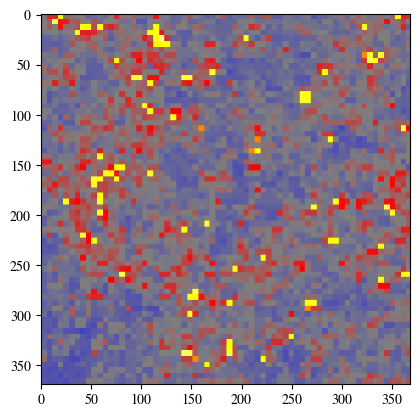

--- Answer ---
{'Omega_m': 0.13232421875, 'sigma_8': 1.325048804283142}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of yellow and white regions suggests significant matter overdensities, indicating galaxy clusters. These clusters are more frequent and prominent, suggesting a higher matter density in the universe. The red regions, which are less dense than clusters but still above average, indicate areas of moderate overdensity. The blue regions represent voids, areas with significantly less matter. The balance between these voids and clusters provides insight into the matter distribution. A higher frequency of clusters compared to voids suggests a higher Omega_m, indicating a universe with more matter. The presence of distinct clusters and voids also suggests a higher sigma_8, reflecting significan

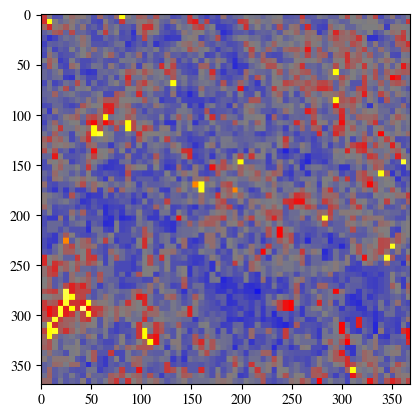

--- Answer ---
{'Omega_m': 0.3597656190395355, 'sigma_8': 0.9263671636581421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of blue areas indicates voids, where the matter density is significantly lower than average. These voids suggest a lower Omega_m, as they represent underdense regions. The red and yellow areas indicate higher density regions, with yellow representing clusters where the density exceeds 3 standard deviations. The presence of these clusters suggests a higher sigma_8, as they indicate significant matter clumping. The balance between the voids and clusters in this map suggests a universe with moderate matter density and significant structure formation. The presence of both voids and clusters in relatively equal measure suggests a balanced cosmological model, with Omega_m and sigma_8 

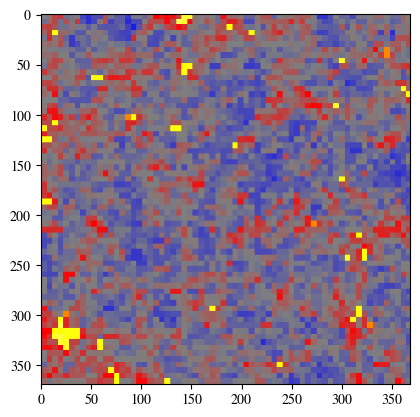

--- Answer ---
{'Omega_m': 0.4073242247104645, 'sigma_8': 0.7625488042831421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of blue areas indicates voids, where the matter density is significantly below average. These voids suggest a lower Omega_m, as they represent underdense regions. The red and yellow areas indicate higher density regions, with yellow representing clusters where the density exceeds 3 standard deviations. The presence of these clusters suggests a higher sigma_8, as it indicates significant matter clumping. The map shows a balanced mix of voids and clusters, suggesting moderate values for both Omega_m and sigma_8. The distribution is not overly dominated by either voids or clusters, indicating a universe with a moderate matter density and a moderate level of structure formation.
---

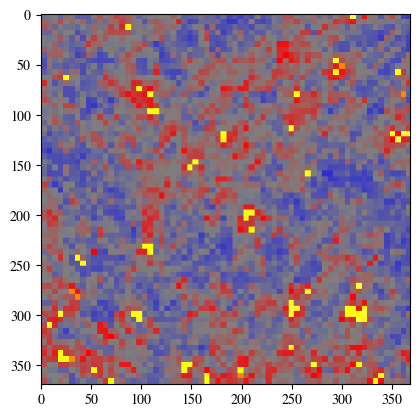

--- Answer ---
{'Omega_m': 0.3726562559604645, 'sigma_8': 0.7066406011581421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with varying colors indicating different standard deviations from the mean. The presence of numerous yellow and white regions suggests a significant number of high-density clusters, indicating a higher matter density in the universe. This implies a higher Omega_m value, as more matter is present to form these clusters. The red regions, which are less dense than the yellow and white but still above average, further support this observation. The blue areas represent voids, indicating regions of lower matter density. The balance between these voids and clusters can help infer sigma_8, which measures the amplitude of matter fluctuations. The presence of both significant clusters and voids suggests a moderate to high sigma_8, as there is a noticeable contrast in density 

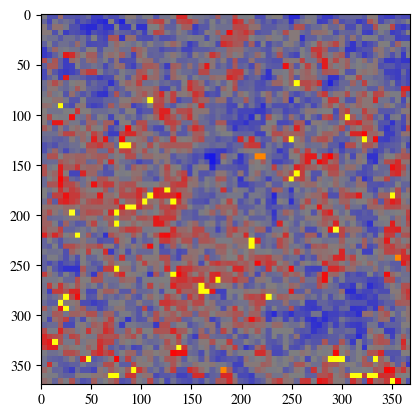

--- Answer ---
{'Omega_m': 0.3470703065395355, 'sigma_8': 0.6446288824081421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous yellow and red regions suggests a significant number of clusters, indicating areas of high matter density. These clusters are represented by values above 3 standard deviations, with yellow indicating the highest density. The blue regions represent voids, areas of low matter density, below -3 standard deviations. The balance between these clusters and voids provides insight into the matter density parameter, Omega_m, and the amplitude of matter fluctuations, sigma_8. A map with many clusters and fewer voids suggests a higher Omega_m and sigma_8, as it indicates a universe with more matter and stronger gravitational clustering. Conversely, more voids would suggest lowe

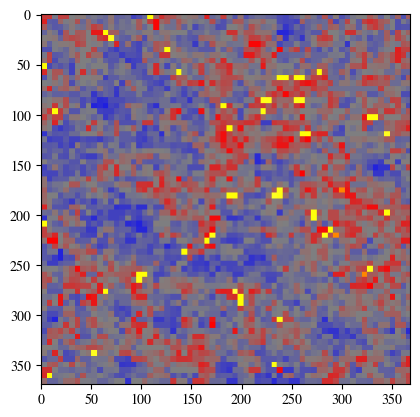

--- Answer ---
{'Omega_m': 0.4979492127895355, 'sigma_8': 0.5828613042831421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous yellow regions suggests a significant number of clusters, indicating areas with high matter density. These clusters are surrounded by red areas, which are also above average density but not as dense as the clusters. The blue regions represent voids, areas with lower than average matter density. The balance between these voids and clusters can provide insights into the cosmological parameters. A higher number of clusters and fewer voids typically suggest a higher value of Omega_m, indicating a universe with more matter. The presence of distinct clusters and voids also suggests a higher sigma_8, reflecting greater matter density fluctuations. Based on the observed dist

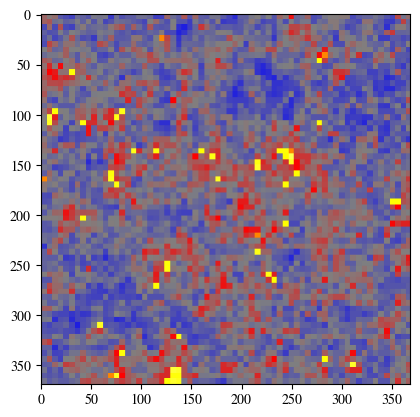

--- Answer ---
{'Omega_m': 0.39531248807907104, 'sigma_8': 0.8179687261581421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous yellow regions indicates a significant number of clusters, suggesting a higher matter density. These clusters are areas where the density exceeds 3 standard deviations, implying a higher Omega_m, which represents the matter density parameter. The red areas, which are slightly less dense than the clusters, also suggest a relatively high matter density but not enough to form clusters. The blue regions indicate voids, where the density is significantly lower, but they are less prevalent compared to the clusters. The balance between these voids and clusters can help infer sigma_8, the amplitude of matter fluctuations. The presence of many clusters and fewer voids sugges

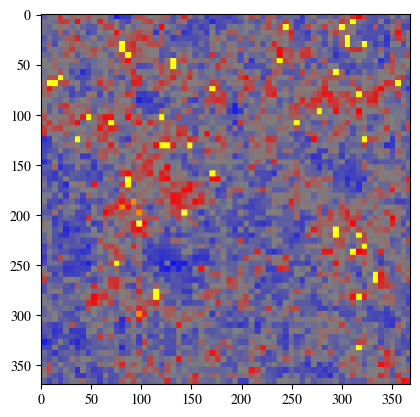

--- Answer ---
{'Omega_m': 0.4175781309604645, 'sigma_8': 0.7662109136581421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous yellow regions indicates a significant number of clusters, suggesting a higher matter density. These clusters are areas where the density exceeds 3 standard deviations, indicating a high concentration of matter. The red areas, which are slightly less dense than the yellow clusters, also suggest a substantial presence of matter but not enough to form clusters. The blue regions represent voids, areas with significantly lower matter density, below -3 standard deviations. The balance between these voids and clusters can help infer cosmological parameters. A higher number of clusters and fewer voids typically suggest a higher Omega_m, indicating a universe with more matte

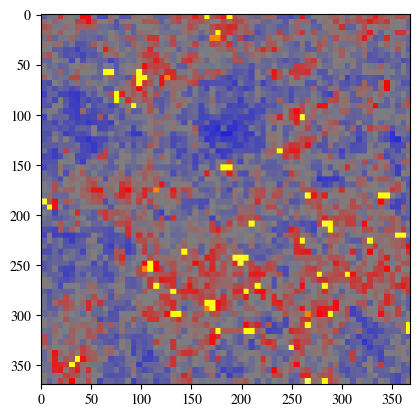

--- Answer ---
{'Omega_m': 0.23857422173023224, 'sigma_8': 0.8094238042831421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of blue regions indicates voids, where the matter density is significantly lower than average. These voids are crucial for understanding the large-scale structure of the universe. The red regions, which are more prevalent, suggest areas of higher matter density but not quite reaching the threshold of clusters. The yellow spots, although less frequent, indicate clusters where the matter density is significantly higher, surpassing 3 standard deviations. The balance between these voids and clusters can inform us about the cosmological parameters Omega_m and sigma_8. A higher frequency of clusters and fewer voids would suggest a higher Omega_m and sigma_8, indicating a denser unive

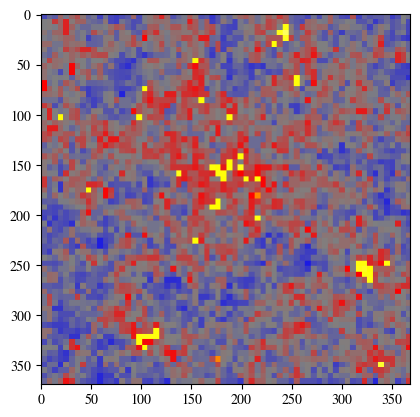

--- Answer ---
{'Omega_m': 0.28242188692092896, 'sigma_8': 0.5103515386581421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with distinct features. The presence of several yellow regions indicates significant matter overdensities, suggesting the presence of galaxy clusters. These clusters are surrounded by red areas, which are also overdense but not as extreme. The blue regions represent underdense areas or voids. The balance between these voids and clusters provides insights into the cosmological parameters. A higher density of clusters suggests a higher value of Omega_m, indicating more matter in the universe. The presence of both significant clusters and voids suggests a moderate to high value of sigma_8, reflecting the amplitude of matter fluctuations. The map's features suggest a universe with a relatively high matter density and significant structure formation.
--- Claims ---
['Th

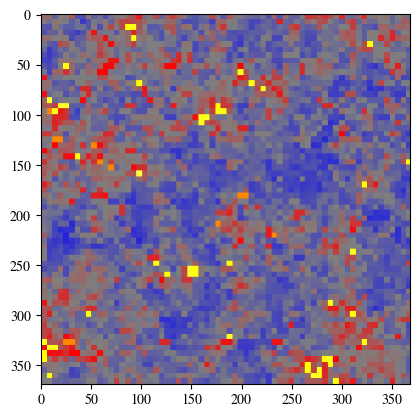

--- Answer ---
{'Omega_m': 0.31669920682907104, 'sigma_8': 0.8484863042831421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of blue regions indicates voids, where the matter density is significantly lower than average. These voids are crucial for understanding the large-scale structure of the universe. The gray areas represent average density, while the red regions indicate areas with higher density but not high enough to be considered clusters. The yellow areas, which are sparse, represent clusters where the density is significantly higher, indicating a concentration of mass. The distribution and size of these clusters and voids provide insights into the values of Omega_m and sigma_8. A higher number of clusters and fewer voids would suggest a higher Omega_m and sigma_8, indicating a denser univers

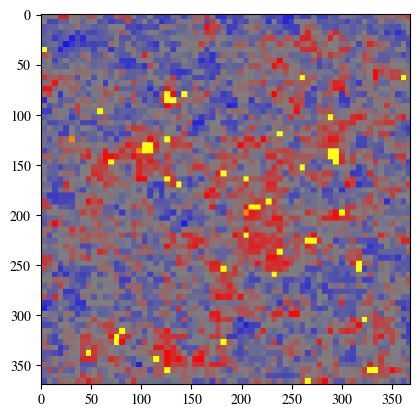

--- Answer ---
{'Omega_m': 0.4681640565395355, 'sigma_8': 0.5137695074081421}
--- LLM Pred Answer ---
{'Omega_m': 0.3, 'sigma_8': 0.8}
--- LLM Pred Explanation ---
The weak lensing map shows a distribution of matter density with various colors indicating different standard deviations from the mean. The presence of numerous yellow regions indicates a significant number of clusters, suggesting a higher matter density. These clusters are areas where the density exceeds 3 standard deviations, implying a higher Omega_m, which represents the matter density parameter. The red regions, which are less dense than the yellow but still above average, suggest a moderate level of matter density. The blue areas indicate voids, where the density is below average, but these are less prevalent than the clusters. The balance between these voids and clusters can help infer sigma_8, the amplitude of matter fluctuations. The presence of many clusters and fewer voids suggests a higher sigma_8, indicating str

In [44]:
import matplotlib.pyplot as plt

for i in range(len(massmaps_examples)):
    plt.figure()
    plt.imshow(massmap_to_pil_norm(massmaps_examples[i].input))
    plt.show()
    print('==============')
    print('--- Answer ---')
    print(massmaps_examples[i].ground_truth)
    print('--- LLM Pred Answer ---')
    print(massmaps_examples[i].llm_prediction)
    print('--- LLM Pred Explanation ---')
    print(massmaps_examples[i].llm_explanation)
    print('--- Claims ---')
    print(massmaps_examples[i].claims)
    
    print('--- Scores (original (s + c), deepresesarch (s + c), claim) ---')
    for j in range(len(massmaps_examples[i].relevant_claims)):
        print(massmaps_examples[i].alignment_scores[j], 
              massmaps_examples[i].alignment_categories[j], 
              massmaps_examples_deepresearch[i].alignment_scores[j], 
              massmaps_examples_deepresearch[i].alignment_categories[j], '|',
              massmaps_examples[i].relevant_claims[j])
    # print('--- Relevant Claims ---')
    # print(massmaps_examples[i].relevant_claims)
    # print('--- Alignment Scores Original ---')
    # if massmaps_examples[i].alignment_scores == massmaps_examples_deepresearch[i].alignment_scores:
    #     same += 1
    # elif massmaps_examples[i].alignment_scores > massmaps_examples_deepresearch[i].alignment_scores:
    #     old_high += 1
    # else:
    #     new_high += 1
# print(same, old_high, new_high)

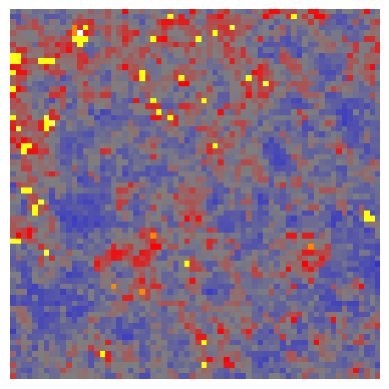

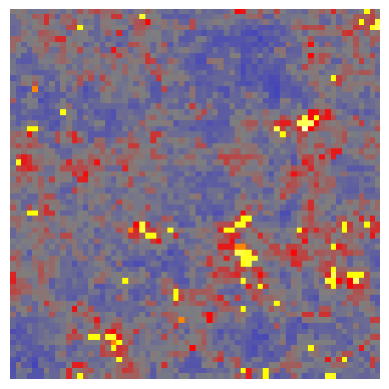

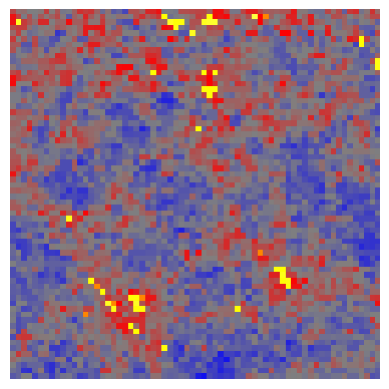

In [47]:
import matplotlib.pyplot as plt

# for i in range(len(massmaps_examples)):
for i in range(3):
    plt.figure()
    plt.imshow(massmap_to_pil_norm(massmaps_examples[i].input))
    plt.axis('off')
    plt.savefig(f'deepresearch_examples/{i}.Omega{massmaps_examples[i].ground_truth["Omega_m"]}.sigma{massmaps_examples[i].ground_truth["sigma_8"]}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
#     print('==============')
#     print('--- Answer ---')
#     print(massmaps_examples[i].ground_truth)
#     print('--- LLM Pred Answer ---')
#     print(massmaps_examples[i].llm_prediction)
#     print('--- LLM Pred Explanation ---')
#     print(massmaps_examples[i].llm_explanation)
#     print('--- Claims ---')
#     print(massmaps_examples[i].claims)
    
#     print('--- Scores (original (s + c), deepresesarch (s + c), claim) ---')
#     for j in range(len(massmaps_examples[i].relevant_claims)):
#         print(massmaps_examples[i].alignment_scores[j], 
#               massmaps_examples[i].alignment_categories[j], 
#               massmaps_examples_deepresearch[i].alignment_scores[j], 
#               massmaps_examples_deepresearch[i].alignment_categories[j], '|',
#               massmaps_examples[i].relevant_claims[j])
    # print('--- Relevant Claims ---')
    # print(massmaps_examples[i].relevant_claims)
    # print('--- Alignment Scores Original ---')
    # if massmaps_examples[i].alignment_scores == massmaps_examples_deepresearch[i].alignment_scores:
    #     same += 1
    # elif massmaps_examples[i].alignment_scores > massmaps_examples_deepresearch[i].alignment_scores:
    #     old_high += 1
    # else:
    #     new_high += 1
# print(same, old_high, new_high)

In [33]:
massmaps_examples[0].__dict__.keys()

dict_keys(['input', 'ground_truth', 'llm_prediction', 'llm_explanation', 'claims', 'relevant_claims', 'alignment_scores', 'alignment_categories'])